#### Jake Dineen
#### Homework 1
#### Structured Data Processing

Task

In addition to the program that you write, you should write a small report. In it you should provide:

- Data and its source
- Description of your data exploration and data cleaning steps
- At least two clearly stated comparison questions with the unit of analysis, the comparison values, and how they are computed
- Brief description of the program
- Description of the output files

For this assignment I'll be looking at some US Census data via the following repository:

ml/machine-learning-databases/adult/adult.data

I've chosen to write this all in 'Markdown' type format via Jupyter Notebooks to keep my code and responses together, and to allow for easier to follow analysis.

There are 48842 instances x 14 attributes available, including some demographic and socioeconomic responses. The data was collected from the 1994 Census Database. Overall, the main goal of the dataset is to predict whether or not a person makes >=50k based on the various regressors, but because this task is more exploratory, I'm not sure if I will use a modeling technique to derive information - Although I may, because I can show feature ranking of gradient boosted trees and see which of these variables is the most influential on yearly income.

A variable dictionary, as defined by the site:

- age: continuous.
- workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- fnlwgt: continuous.
- education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
- education-num: continuous.
- marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
- occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
- relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
- race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
- sex: Female, Male.
- capital-gain: continuous.
- capital-loss: continuous.
- hours-per-week: continuous.
- native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

Some of these may be superflous for the task at hand, and others could likely be binned down to reduce variance, so I might toy around with some feature engineering for EDA/inference.

#### Reading in the data

I am reading the data in from a csv html link. Pandas seems like the easiest way to process this data and put it into a dataframe, which is what I am looking to do.



In [62]:
import csv
import numpy as np
import pandas as pd
import sklearn
import os

#Simple try catch for reading in the data. 
try:
    #Reading in the data
    data = 'http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
    
    #Read in the data into a pandas df with column names (col names not included via the weblink)
    data = pd.read_csv(data, names = ['Age', 'Workclass', 'finalweight', 'education', 'education_num', 'marital_status',
                              'occupation', 'relationship', 'race', 'sex', 'capitalgain', 'capitalloss', 
                              'hoursperweek', 'native_country', 'Class'])

except:
    print('Something went wrong')

#Print data head for inspection
data.head(n=5)


,Age,Workclass,finalweight,education,education_num,marital_status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native_country,Class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [63]:
print('Read in {} rows & {} columns'.format(data.shape[0], data.shape[1]))

Read in 32561 rows & 15 columns


#### Cleaning the data.
This data is already highly structured, although there are some things that I'd like to do:
- remove the finalweight var. This seems more sequential than anything else. I've worked with this data in the past and still struggle to understand exactly how that weighting is formulated.
- remove education_num as a var. This is redundant as we already have an education variable, and it's slightly more intuitive than a continous count of grade. It will be factorized when modeling anyways, so it makes more sense to have it grouped into more specific bins.
- Look at a histogram of country to see if there's any instances that we'd be better off removing - eg. if Jamaica only has a few observations, it would be tough to account for the variance there.
- Find out about missing values and deal with them through dropping or imputing.

In [64]:
#Remove Specified Columns
colstodrop = ['finalweight', 'education_num']
data.drop(columns =colstodrop, inplace = True) #inplace = true to replace without resaving object
for i in colstodrop:
    print('Dropping',i)
data.head(n=3)

Dropping finalweight
Dropping education_num


,Age,Workclass,education,marital_status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native_country,Class
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K


In [65]:
#Do we have any missing data?
data.isnull().sum()

Age               0
Workclass         0
education         0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capitalgain       0
capitalloss       0
hoursperweek      0
native_country    0
Class             0
dtype: int64

In [66]:
#Basic operations for feature engineering

data = pd.get_dummies(data, columns = ['Class'])
#Rename dummy columns for ease of indexing
data.rename(columns={'Class_ <=50K':'Below50'}, inplace=True)
data.rename(columns={'Class_ >50K':'Above50'}, inplace=True)
data['totalsamples'] = data['Below50'] + data['Above50'] #Sum samples
data['percent_below'] = data['Below50'] / data['totalsamples'] #Division on below threshold
data['percent_above'] = data['Above50'] / data['totalsamples'] #Division on above threshold

This data is highly structured and well put cleaned already. Summing the missing value counts above shows that we have no NaNs, and as such don't have to worry about dropping null values or imputing with a measure of central tendency

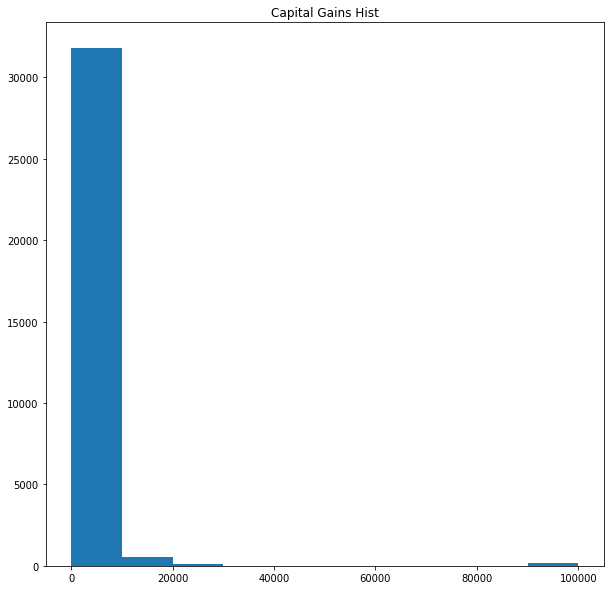

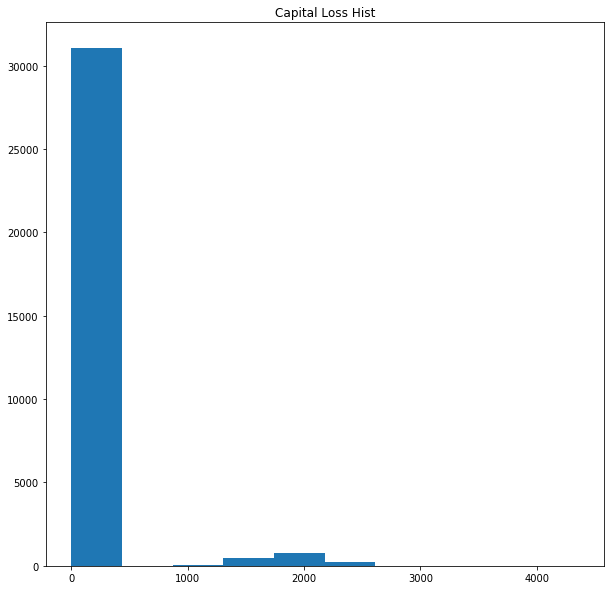

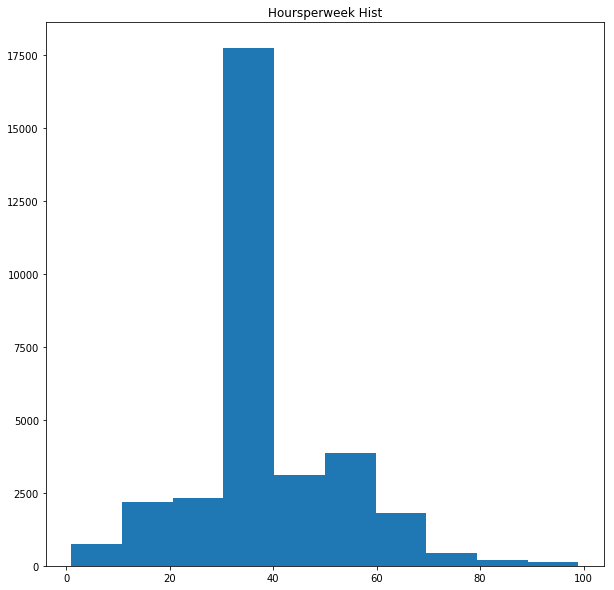

In [67]:
#Some basic plots to visualize data
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10 #Resizing plots
import matplotlib.pyplot as plt
import seaborn as sns
plt.hist(data['capitalgain'])
plt.title('Capital Gains Hist')
plt.show()

plt.hist(data['capitalloss'])
plt.title('Capital Loss Hist')
plt.show()

plt.hist(data['hoursperweek'])
plt.title('Hoursperweek Hist')
plt.show()


#### Question 1:
Let's start by showing the total count of samples within our dataset that belong to each grouping education.

In [68]:
#Get dummies for dependent Var == Class
data1 = data.copy()
#Pandas group by to show distribution
data1

,Age,Workclass,education,marital_status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native_country,Below50,Above50,totalsamples,percent_below,percent_above
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,1,0,1,1.0,0.0
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,1,0,1,1.0,0.0
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,1,0,1,1.0,0.0
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,1,0,1,1.0,0.0
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,1,0,1,1.0,0.0
5,37,Private,Masters,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,1,0,1,1.0,0.0
6,49,Private,9th,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,1,0,1,1.0,0.0
7,52,Self-emp-not-inc,HS-grad,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,0,1,1,0.0,1.0
8,31,Private,Masters,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,0,1,1,0.0,1.0
9,42,Private,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,0,1,1,0.0,1.0


Text(0,0.5,'%Above 50k')

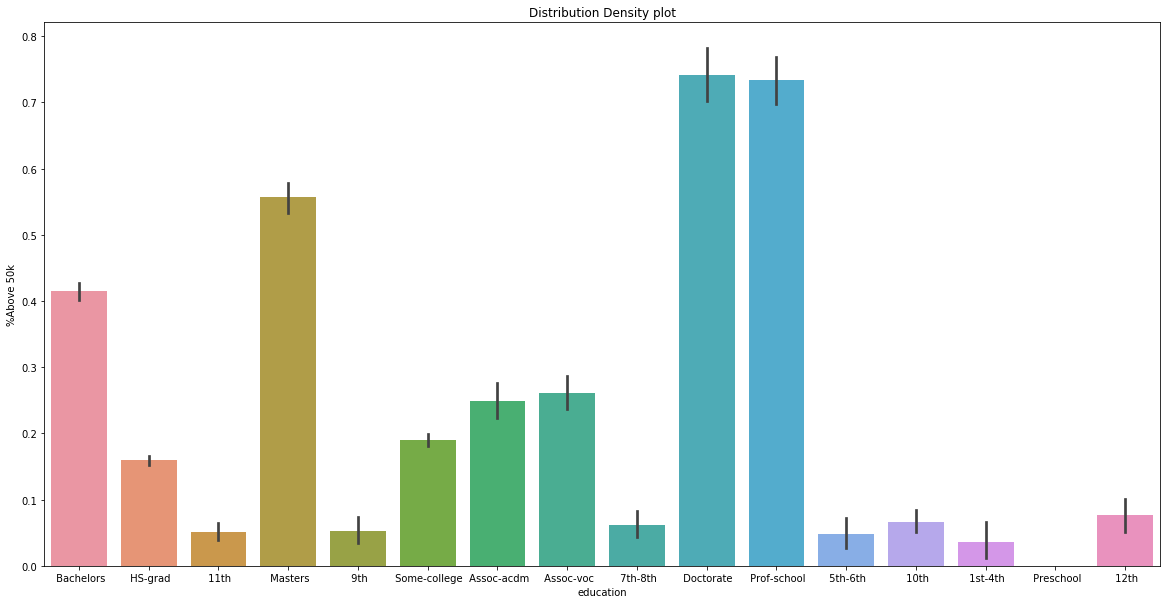

In [69]:
#Barplot with percentage above 50k income
rcParams['figure.figsize'] = 20, 10
sns.barplot(x="education", y="Above50", data=data)
plt.title('Distribution Density plot')
plt.ylabel('%Above 50k')

This table above really helps to show the distribution of our class variable against furthest education level. We can see taht a vast majority of the individuals who have completed high school as their last level of education are increasingly less likely to cross the 50k threshold which divideds our dependent variable.



In [70]:
#Get dummies for dependent Var == Class
data2 = data.copy()
#Pandas group by to show distribution
data2 =data2.groupby(['race', 'sex']).sum() 
#colstodrop = ['Age','capitalgain','capitalloss','hoursperweek']
data2

Age  capitalgain  capitalloss  hoursperweek  \
race                sex                                                       
 Amer-Indian-Eskimo  Female    4417        64808         1721          4353   
                     Male      7144       129650         8908          8102   
 Asian-Pac-Islander  Female   12141       269339        17595         12954   
                     Male     27078      1266675        83419         28738   
 Black               Female   58863       803303        70676         57277   
                     Male     59124      1102151       117967         62756   
 Other               Female    3453        27759         3955          3916   
                     Male      5614       225534        12595          6780   
 White               Female  318126      4957141       565105        313676   
                     Male    760297     26242964      1960759        818132   

                             Below50  Above50  totalsamples  percent_below  \
race                sex                                                      
 Amer-Indian-Eskimo  Female    107.0     12.0         119.0          107.0   
                     Male      168.0     24.0         192.0          168.0   
 Asian-Pac-Islander  Female    303.0     43.0         346.0          303.0   
                     Male      460.0    233.0         693.0          460.0   
 Black               Female   1465.0     90.0        1555.0         1465.0   
                     Male     1272.0    297.0        1569.0         1272.0   
 Other               Female    103.0      6.0         109.0          103.0   
                     Male      143.0     19.0         162.0          143.0   
 White               Female   7614.0   1028.0        8642.0         7614.0   
                     Male    13085.0   6089.0       19174.0        13085.0   

                             percent_above  
race                sex                     
 Amer-Indian-Eskimo  Female           12.0  
                     Male             24.0  
 Asian-Pac-Islander  Female           43.0  
                     Male            233.0  
 Black               Female           90.0  
                     Male            297.0  
 Other               Female            6.0  
                     Male             19.0  
 White               Female         1028.0  
                     Male           6089.0

Breaking it down by race and sex, which involves grouping on a passed listlike structure of vars, shows the above tabular output. 

There is often talk of an income gap amongst races and genders, and this speaks a little bit to that point, although it could be a bit misleading. The total count of white males represented in this dataset are 19k/32k, which is right about 60% of the total. Class imbalance often lends itself to machine learning bias, from what I've read. Stratified sampling might be a better way break up the imbalance.

Even more interesting, however, is the fact that white males are not responsible for the biggest percent of race/sex over the threeshold - That belong to Asian-Pac-Islander males. 



#### Question 2
Let's see if a combination of demographic data measured against hours worked shows us anything. Specifically, I want to look at all races/sexes for education level above a Bachelors to see if I can identify any disparities.

In [71]:
#Get dummies for dependent Var == Class
#Rename dummy columns for ease of indexing
data3 = data.copy()
#Filter the education column on a string match for secondary education
data3 = data3[data3['education'].str.contains("Bachelors|Masters|Doctorate|Prof-School")] 
#Pull out necessary columns
data3 = data3[['education', 'race', 'sex', 'hoursperweek', 'Above50', 'Below50']]
#Group by with a twist. Use .agg for calling specific measures against columns
data3 = data3.groupby(['race', 'sex', 'education']).agg({'hoursperweek':'mean', 'Above50': 'sum', 'Below50': 'sum'})
#Same Ops as earlier for density
data3['totalsamples'] = data3['Below50'] + data3['Above50'] #Sum samples
data3['percent_below'] = data3['Below50'] / data3['totalsamples'] #Division on below threshold
data3['percent_above'] = data3['Above50'] / data3['totalsamples'] #Division on above threshold
data3

hoursperweek  Above50  Below50  \
race                sex     education                                    
 Amer-Indian-Eskimo  Female  Bachelors     41.875000      3.0      5.0   
                             Doctorate     50.000000      1.0      1.0   
                             Masters       50.000000      2.0      0.0   
                     Male    Bachelors     42.923077      5.0      8.0   
                             Doctorate     40.000000      1.0      0.0   
                             Masters       40.000000      1.0      2.0   
 Asian-Pac-Islander  Female  Bachelors     39.949495     18.0     81.0   
                             Masters       37.352941      5.0     12.0   
                     Male    Bachelors     42.084211     79.0    111.0   
                             Doctorate     44.964286     18.0     10.0   
                             Masters       40.647887     38.0     33.0   
 Black               Female  Bachelors     40.393939     27.0    138.0   
                             Doctorate     34.750000      3.0      1.0   
                             Masters       38.473684     15.0     23.0   
                     Male    Bachelors     42.418182     69.0     96.0   
                             Doctorate     46.142857      6.0      1.0   
                             Masters       41.500000     25.0     23.0   
 Other               Female  Bachelors     38.142857      3.0     11.0   
                             Masters       37.000000      1.0      3.0   
                     Male    Bachelors     45.000000      2.0     17.0   
                             Doctorate     45.000000      1.0      1.0   
                             Masters       40.000000      1.0      2.0   
 White               Female  Bachelors     39.148537    288.0   1045.0   
                             Doctorate     47.862500     46.0     34.0   
                             Masters       41.456842    156.0    319.0   
                     Male    Bachelors     44.226933   1727.0   1622.0   
                             Doctorate     47.128028    230.0     59.0   
                             Masters       45.550847    715.0    347.0   

                                        totalsamples  percent_below  \
race                sex     education                                 
 Amer-Indian-Eskimo  Female  Bachelors           8.0       0.625000   
                             Doctorate           2.0       0.500000   
                             Masters             2.0       0.000000   
                     Male    Bachelors          13.0       0.615385   
                             Doctorate           1.0       0.000000   
                             Masters             3.0       0.666667   
 Asian-Pac-Islander  Female  Bachelors          99.0       0.818182   
                             Masters            17.0       0.705882   
                     Male    Bachelors         190.0       0.584211   
                             Doctorate          28.0       0.357143   
                             Masters            71.0       0.464789   
 Black               Female  Bachelors         165.0       0.836364   
                             Doctorate           4.0       0.250000   
                             Masters            38.0       0.605263   
                     Male    Bachelors         165.0       0.581818   
                             Doctorate           7.0       0.142857   
                             Masters            48.0       0.479167   
 Other               Female  Bachelors          14.0       0.785714   
                             Masters             4.0       0.750000   
                     Male    Bachelors          19.0       0.894737   
                             Doctorate           2.0       0.500000   
                             Masters             3.0       0.666667   
 White               Female  Bachelors        1333.0       0.783946   
                             Doctorate      

In [72]:
# Subset on just Bachelors
data4 = data.copy()
data4 = data4[data4['education'].str.contains("Bachelors")] 
#Pull out necessary columns
data4 = data4[['education', 'race', 'sex', 'hoursperweek', 'Above50', 'Below50']]
#Group by with a twist. Use .agg for calling specific measures against columns
data4 = data4.groupby(['race', 'sex', 'education']).agg({'hoursperweek':'mean', 'Above50': 'sum', 'Below50': 'sum'})
#Same Ops as earlier for density
data4['totalsamples'] = data4['Below50'] + data4['Above50'] #Sum samples
data4['percent_below'] = np.round(data4['Below50'] / data4['totalsamples'] * 100,2) #Division on below threshold
data4['percent_above'] = np.round(data4['Above50'] / data4['totalsamples'] * 100,2) #Division on above threshold

data4.sort_values(by= 'percent_above', ascending= False) #Sort desc

hoursperweek  Above50  Below50  \
race                sex     education                                    
 White               Male    Bachelors     44.226933   1727.0   1622.0   
 Black               Male    Bachelors     42.418182     69.0     96.0   
 Asian-Pac-Islander  Male    Bachelors     42.084211     79.0    111.0   
 Amer-Indian-Eskimo  Male    Bachelors     42.923077      5.0      8.0   
                     Female  Bachelors     41.875000      3.0      5.0   
 White               Female  Bachelors     39.148537    288.0   1045.0   
 Other               Female  Bachelors     38.142857      3.0     11.0   
 Asian-Pac-Islander  Female  Bachelors     39.949495     18.0     81.0   
 Black               Female  Bachelors     40.393939     27.0    138.0   
 Other               Male    Bachelors     45.000000      2.0     17.0   

                                        totalsamples  percent_below  \
race                sex     education                                 
 White               Male    Bachelors        3349.0          48.43   
 Black               Male    Bachelors         165.0          58.18   
 Asian-Pac-Islander  Male    Bachelors         190.0          58.42   
 Amer-Indian-Eskimo  Male    Bachelors          13.0          61.54   
                     Female  Bachelors           8.0          62.50   
 White               Female  Bachelors        1333.0          78.39   
 Other               Female  Bachelors          14.0          78.57   
 Asian-Pac-Islander  Female  Bachelors          99.0          81.82   
 Black               Female  Bachelors         165.0          83.64   
 Other               Male    Bachelors          19.0          89.47   

                                        percent_above  
race                sex     education                  
 White               Male    Bachelors          51.57  
 Black               Male    Bachelors          41.82  
 Asian-Pac-Islander  Male    Bachelors          41.58  
 Amer-Indian-Eskimo  Male    Bachelors          38.46  
                     Female  Bachelors          37.50  
 White               Female  Bachelors          21.61  
 Other               Female  Bachelors          21.43  
 Asian-Pac-Islander  Female  Bachelors          18.18  
 Black               Female  Bachelors          16.36  
 Other               Male    Bachelors          10.53

What I've done here is isolate people that have Bachelors degrees, as it's a bit more robust than looking at grouping of Masters and Doctorates. Similar operations were performed, and I sorted by the percent above > 50k. 

I think this is a very interesting table for what it is, although there the data is not very representative of race splits in the US climate..

A few things of note:
- White males w/ Bachelors degrees have the highest density dist./likelihood of making above 50k in the data sampled (Bach. Degrees).
- The gap between white and black males with a Bachelors degree is not as supreme as one may have thought.
- Women, although most of the total count skews toward white women, are not as equally represented amongst the proportion of people making over 50k with a Bachelors degree.
- There seems to be some mild correlation between average hours worked per week and percent above the threshold. This analysis could likely be more thorough if raw salary numbers were included.




In [73]:
#Modeling the data
#Simple try catch for reading in the data. 
try:
    #Reading in the data
    data = 'http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
    
    #Read in the data into a pandas df with column names (col names not included via the weblink)
    data = pd.read_csv(data, names = ['Age', 'Workclass', 'finalweight', 'education', 'education_num', 'marital_status',
                              'occupation', 'relationship', 'race', 'sex', 'capitalgain', 'capitalloss', 
                              'hoursperweek', 'native_country', 'Class'])

except:
    print('Something went wrong')

y = data['Class']
X = data
X.drop(columns= 'Class', inplace= True)
X = pd.get_dummies(X)

Automatically created module for IPython interactive environment
Feature ranking:
1. feature 1 (0.168577)
2. feature 0 (0.150220)
3. feature 5 (0.093361)
4. feature 3 (0.064950)
5. feature 33 (0.064662)
6. feature 53 (0.038794)
7. feature 2 (0.034152)
8. feature 35 (0.031232)
9. feature 42 (0.022425)
10. feature 4 (0.022382)
11. feature 48 (0.019236)
12. feature 24 (0.018491)
13. feature 54 (0.012907)
14. feature 27 (0.012613)
15. feature 56 (0.012560)
16. feature 58 (0.011205)
17. feature 65 (0.011127)
18. feature 26 (0.010309)
19. feature 10 (0.009506)
20. feature 64 (0.009100)
21. feature 12 (0.008005)
22. feature 29 (0.007700)
23. feature 46 (0.007654)
24. feature 11 (0.006954)
25. feature 31 (0.006730)
26. feature 63 (0.006388)
27. feature 105 (0.006290)
28. feature 30 (0.006195)
29. feature 41 (0.005964)
30. feature 50 (0.005958)
31. feature 57 (0.005762)
32. feature 25 (0.005456)
33. feature 8 (0.005446)
34. feature 7 (0.005210)
35. feature 39 (0.004987)
36. feature 61 (0.004786

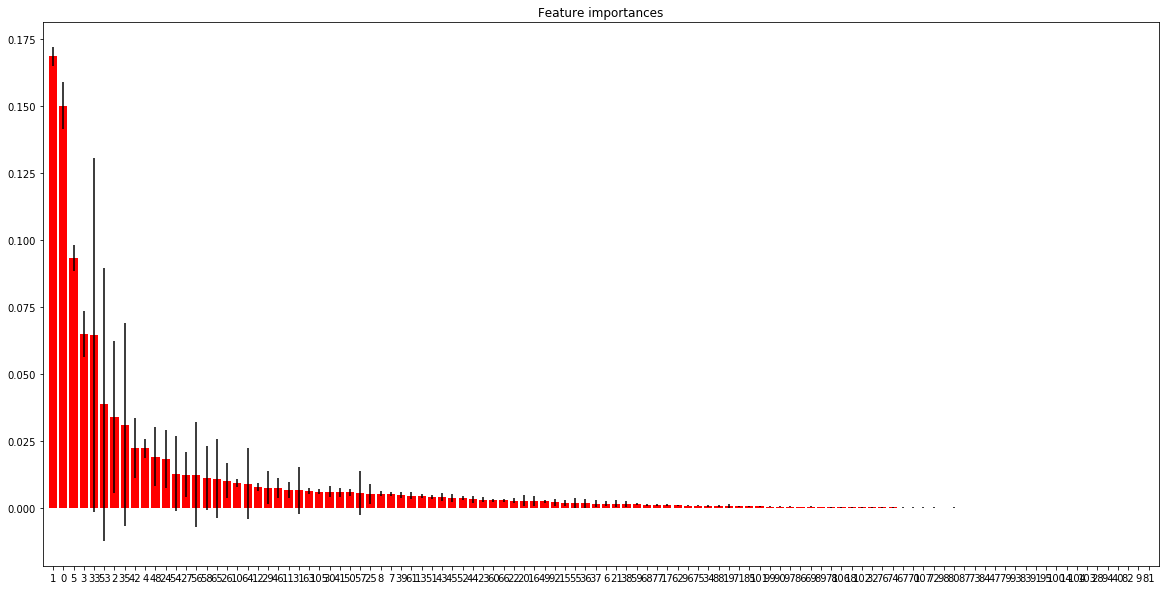

In [74]:
#Code borrowed from Sklearn Docs

print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier


# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()


Top 5 feats.:
1. feature 1 (0.168577) - finalweight
2. feature 0 (0.150220) - age
3. feature 5 (0.093361) - hours per week
4. feature 3 (0.064950)- capital gain
5. feature 33 (0.064662) - marital_status_ Married-AF-spouse


This is essentially showing us the information gain/feature ranking of our independent vars in a tree based model architecture. It isn't incredibly well designed because I had to turn it into a sparse matrix to run the numerics with the categorical variables, but it is intuitive in letting us know that age and 'finalweight' are driving most of our inference ability. If we grouped/binned some of the cat vars better, we'd likely see different results. For the case of this assignment, there were no train test splits and the entire data set was modelled.

Most of what I've used here was not acquired (yet) from course lectures or asynch materials. I chose to use pandas because I was dealing with highly structured, tabular data, so there wasn't much need to deal with numpy arrays, lists or dicts. 

One thing that I really don't like about using pandas dataframes is the difficulty that comes along with iterating through them. As we move along to unstructured data, particularly Json readins, I'm sure I'll be using a lot more of the aforementioned data structures for mapping/indexing and looping.

#### Appendix
- Percent Above Threshold computed by taking sum of counts of class > 50k/total samples.
- Percent Below Threshold computed by taking sum of counts of class < 50k/total samples.


#### References
- Sklearn Docs
- Pandas Docs
- Numpy Docs
- Stackoverflow